# Customer Segmentation with RFM Analysis

**Business Problem**

An England-based retail company aims to segment its customers and develop marketing strategies based on these segments. They believe that conducting marketing campaigns targeting customer segments exhibiting common behaviors will lead to increased revenue. RFM analysis will be utilized for customer segmentation.

**About Dataset**

The dataset named "Online Retail II" contains the online sales transactions of an England-based retail company between 01/12/2009 and 09/12/2011. The company's product catalog consists of gift items, and it is known that most of its customers are wholesalers.

P.S.: If the invoice number (**InvoiceNo**) starts with the code "C," it indicates that the transaction has been canceled.

## 1. Importing Packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.set_option('display.width',1000)

## 2. Loading Dataset

In [2]:
# Read the Online_Retail.xlsx file and store the data in online_retail_data DataFrame for further processing
online_retail_data = pd.read_excel('/datasets/Online_Retail.xlsx')

# Create a copy of the online_retail_data DataFrame for keeping the original data unchanged
online_retail_copy = online_retail_data.copy()

## 3. Initial Data Cleaning and Preprocessing

By performing these manipulations immediately after loading the dataset, you ensure that the subsequent analysis and RFM segmentation are conducted on a clean and reliable dataset.

In [3]:
# Drop rows with missing CustomerID as they won't contribute to customer segmentation analysis
online_retail_data.dropna(subset=['CustomerID'], inplace=True)

# Identify and drop rows with InvoiceNo starting with 'C' as they represent canceled transactions
drop_index = online_retail_data[online_retail_data['InvoiceNo'].str.startswith('C') == True].index
online_retail_data.drop(drop_index, inplace=True)

## 4. Exploratory Data Analysis

### 4.1. Preview of Data

In [4]:
# Display the first few rows of the DataFrame
print("Top rows of the dataset:")
print(online_retail_data.head())

Top rows of the dataset:
  InvoiceNo StockCode                          Description  Quantity         InvoiceDate  UnitPrice  CustomerID         Country
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6 2010-12-01 08:26:00       2.55    17850.00  United Kingdom
1    536365     71053                  WHITE METAL LANTERN         6 2010-12-01 08:26:00       3.39    17850.00  United Kingdom
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8 2010-12-01 08:26:00       2.75    17850.00  United Kingdom
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6 2010-12-01 08:26:00       3.39    17850.00  United Kingdom
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6 2010-12-01 08:26:00       3.39    17850.00  United Kingdom


### 4.2. Dataset Information

In [5]:
# Get the number of rows and columns in the DataFrame
rows, columns = online_retail_data.shape

# Print the information about the dataset
print(f"The dataset contains {rows} rows and {columns} columns.")

print()

# Display the summary information of the DataFrame
print("Dataset Information:")
online_retail_data.info()

The dataset contains 397924 rows and 8 columns.

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 397924 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    397924 non-null  object        
 1   StockCode    397924 non-null  object        
 2   Description  397924 non-null  object        
 3   Quantity     397924 non-null  int64         
 4   InvoiceDate  397924 non-null  datetime64[ns]
 5   UnitPrice    397924 non-null  float64       
 6   CustomerID   397924 non-null  float64       
 7   Country      397924 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 27.3+ MB


### 4.3. Summary Statistics

In [6]:
# Display the summary statistics of the DataFrame
print("Summary Statistics:")
print(online_retail_data.describe().T)

Summary Statistics:
               count     mean     std      min      25%      50%      75%      max
Quantity   397924.00    13.02  180.42     1.00     2.00     6.00    12.00 80995.00
UnitPrice  397924.00     3.12   22.10     0.00     1.25     1.95     3.75  8142.75
CustomerID 397924.00 15294.32 1713.17 12346.00 13969.00 15159.00 16795.00 18287.00


## 5. RFM Analysis

**RFM** stands for *Recency*, *Frequency*, and *Monetary*. It is a popular marketing and customer segmentation technique used to analyze and categorize customers based on their past behavior and transaction data. The **RFM** model is widely used in customer relationship management (**CRM**) and marketing strategies to identify valuable customer segments and tailor personalized marketing efforts.

*Here are the components of* **RFM**:

**Recency (R)**:
*Recency* measures the time elapsed since a customer's last purchase or interaction with the business. Customers who have made recent purchases are often considered more engaged and likely to be responsive to marketing efforts.

**Frequency (F)**:
*Frequency* measures the number of times a customer has made a purchase or interacted with the business over a specific period. Customers with higher purchase frequency are typically more loyal and valuable to the business.

**Monetary (M)**:
*Monetary* represents the total monetary value of a customer's transactions within a specific timeframe. Customers with higher monetary value are those who have spent more money on their purchases.

By combining these three components, businesses can segment their customers into different groups or categories, such as "*High-Value Customers*," "*Loyal Customers*," "*Churn Risk Customers*," and "*Inactive Customers*." Each group can then be targeted with specific marketing strategies to optimize customer retention, cross-selling, and customer satisfaction. **RFM analysis** provides valuable insights to improve customer targeting, increase customer engagement, and drive revenue growth.

### 5.1. Preparing Data for RFM Calculation

In [7]:
######################
## Aggregating Data ##
######################


# Step 1: Calculate revenue for each product in each transaction
# by multiplying quantity and unit price
online_retail_data['Revenue'] = (online_retail_data['Quantity'] * online_retail_data['UnitPrice']).round(2)

# Step 2: Calculate invoice-wise revenue and last invoice date for each customer
invoice_sum = online_retail_data.groupby(['CustomerID', 'InvoiceNo']).agg({
    'InvoiceDate': 'max',        # Get the maximum invoice date (last invoice date)
    'Revenue': 'sum'             # Calculate the sum of revenues for each invoice
}).reset_index()

# Step 3: Calculate customer-wise total revenue, number of orders, and last order date
customer_sum = invoice_sum.groupby('CustomerID').agg({
    'InvoiceDate': 'max',        # Get the maximum invoice date (last order date) for each customer
    'Revenue': 'sum',            # Calculate the total revenue for each customer
    'InvoiceNo': 'count'         # Count the number of orders for each customer
}).reset_index()

# Step 4: Rename columns to have more descriptive names
customer_sum.rename(columns={
    'InvoiceDate': 'LastOrderDate',      # Rename 'InvoiceDate' to 'LastOrderDate'
    'Revenue': 'CustomerValueTotal',     # Rename 'Revenue' to 'CustomerValueTotal'
    'InvoiceNo': 'NumberOfOrders'        # Rename 'InvoiceNo' to 'NumberOfOrders'
}, inplace=True)

# Step 4: Convert 'CustomerID' column to integers
customer_sum['CustomerID'] = customer_sum['CustomerID'].astype(int)

# Display the first few rows of the resulting DataFrame
customer_sum.head()

,CustomerID,LastOrderDate,CustomerValueTotal,NumberOfOrders
0,12346,2011-01-18 10:01:00,77183.60,1
1,12347,2011-12-07 15:52:00,4310.00,7
2,12348,2011-09-25 13:13:00,1797.24,4
3,12349,2011-11-21 09:51:00,1757.55,1
4,12350,2011-02-02 16:01:00,334.40,1


In [8]:
################################
## Creating raw RFM DataFrame ##
################################

# Step 1: Define the analysis date by adding two days to the maximum last order date
analysis_date = customer_sum["LastOrderDate"].max() + dt.timedelta(days=2)

# Step 2: Create a new DataFrame 'rfm' for Recency, Frequency, and Monetary analysis
rfm = pd.DataFrame()

# Step 3: Assign 'CustomerID' column from customer_sum to 'rfm'
rfm["CustomerID"] = customer_sum["CustomerID"]

# Step 4: Calculate the Recency (time since last order) in days and add it to 'rfm'
rfm["recency"] = (analysis_date - customer_sum["LastOrderDate"]).astype('timedelta64[D]')

# Step 5: Add the Frequency (number of orders) from customer_sum to 'rfm'
rfm["frequency"] = customer_sum["NumberOfOrders"]

# Step 6: Add the Monetary value (total customer value) from customer_sum to 'rfm'
rfm["monetary"] = customer_sum["CustomerValueTotal"]

# Display the first few rows of the 'rfm' DataFrame
rfm.head()

,CustomerID,recency,frequency,monetary
0,12346,327.00,1,77183.60
1,12347,3.00,7,4310.00
2,12348,76.00,4,1797.24
3,12349,20.00,1,1757.55
4,12350,311.00,1,334.40


### 5.2. Calculating RF and RFM Scores

In [9]:
# Step 1: Calculate the recency score by dividing customers into 5 equal-size groups based on their recency values
rfm["recency_score"] = pd.qcut(rfm['recency'], 5, labels=[5, 4, 3, 2, 1])

# Step 2: Calculate the frequency score by dividing customers into 5 equal-size groups based on their order frequency rank
rfm["frequency_score"] = pd.qcut(rfm['frequency'].rank(method="first"), 5, labels=[1, 2, 3, 4, 5])

# Step 3: Calculate the monetary score by dividing customers into 5 equal-size groups based on their monetary values
rfm["monetary_score"] = pd.qcut(rfm['monetary'], 5, labels=[1, 2, 3, 4, 5])

# Step 4: Combine recency_score and frequency_score into a single variable RF_SCORE
rfm["RF_SCORE"] = (rfm['recency_score'].astype(str) + rfm['frequency_score'].astype(str))

# Step 5: Combine recency_score, frequency_score, and monetary_score into a single variable RFM_SCORE
rfm["RFM_SCORE"] = (rfm['recency_score'].astype(str) + rfm['frequency_score'].astype(str) + rfm['monetary_score'].astype(str))

# Display the first few rows of the 'rfm' DataFrame
rfm.head()

,CustomerID,recency,frequency,monetary,recency_score,frequency_score,monetary_score,RF_SCORE,RFM_SCORE
0,12346,327.00,1,77183.60,1,1,5,11,115
1,12347,3.00,7,4310.00,5,5,5,55,555
2,12348,76.00,4,1797.24,2,4,4,24,244
3,12349,20.00,1,1757.55,4,1,4,41,414
4,12350,311.00,1,334.40,1,1,2,11,112


### 5.3. Segmenting RF Scores: Categorizing Customers Based on RF Analysis

In [10]:
# Step 1: Define segment definitions using seg_map to make RFM scores more interpretable
seg_map = {
    r'[1-2][1-2]': 'hibernating',
    r'[1-2][3-4]': 'at_Risk',
    r'[1-2]5': 'cant_loose',
    r'3[1-2]': 'about_to_sleep',
    r'33': 'need_attention',
    r'[3-4][4-5]': 'loyal_customers',
    r'41': 'promising',
    r'51': 'new_customers',
    r'[4-5][2-3]': 'potential_loyalists',
    r'5[4-5]': 'champions'
}

# Step 2: Convert the RF_SCORE into segments using seg_map
rfm['segment'] = rfm['RF_SCORE'].replace(seg_map, regex=True)

# Display the first few rows of the 'rfm' DataFrame with segments
rfm.head()

,CustomerID,recency,frequency,monetary,recency_score,frequency_score,monetary_score,RF_SCORE,RFM_SCORE,segment
0,12346,327.00,1,77183.60,1,1,5,11,115,hibernating
1,12347,3.00,7,4310.00,5,5,5,55,555,champions
2,12348,76.00,4,1797.24,2,4,4,24,244,at_Risk
3,12349,20.00,1,1757.55,4,1,4,41,414,promising
4,12350,311.00,1,334.40,1,1,2,11,112,hibernating


### 5.4. Customer Segmentation Visualizations

#### Bar Chart

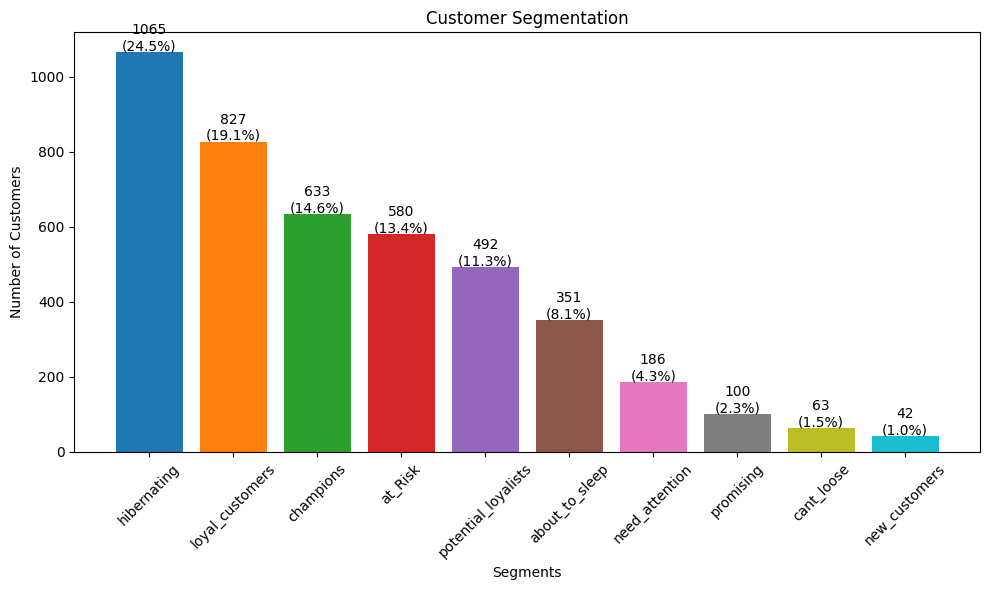

In [11]:
# Step 1: Group the data by segment and count the number of customers in each segment
segment_counts = rfm['segment'].value_counts()
total_customers = segment_counts.sum()
segment_percentages = (segment_counts / total_customers) * 100

# Step 2: Create a bar chart to visualize the segments with colored areas and labels
plt.figure(figsize=(10, 6))
plt.bar(segment_counts.index, segment_counts, color=['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple',
                                                     'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan'])

# Step 3: Add text annotations for segment names, customer count, and percentage
for i, segment in enumerate(segment_counts.index):
    count = segment_counts[segment]
    percentage = segment_percentages[segment]
    plt.text(i, count + 5, f"{count}\n({percentage:.1f}%)", ha='center')

# Step 4: Customize the plot
plt.xlabel('Segments')
plt.ylabel('Number of Customers')
plt.title('Customer Segmentation')
plt.xticks(rotation=45)
plt.tight_layout()

# Step 5: Show the plot
plt.show()


#### RFM Segmentation Plot

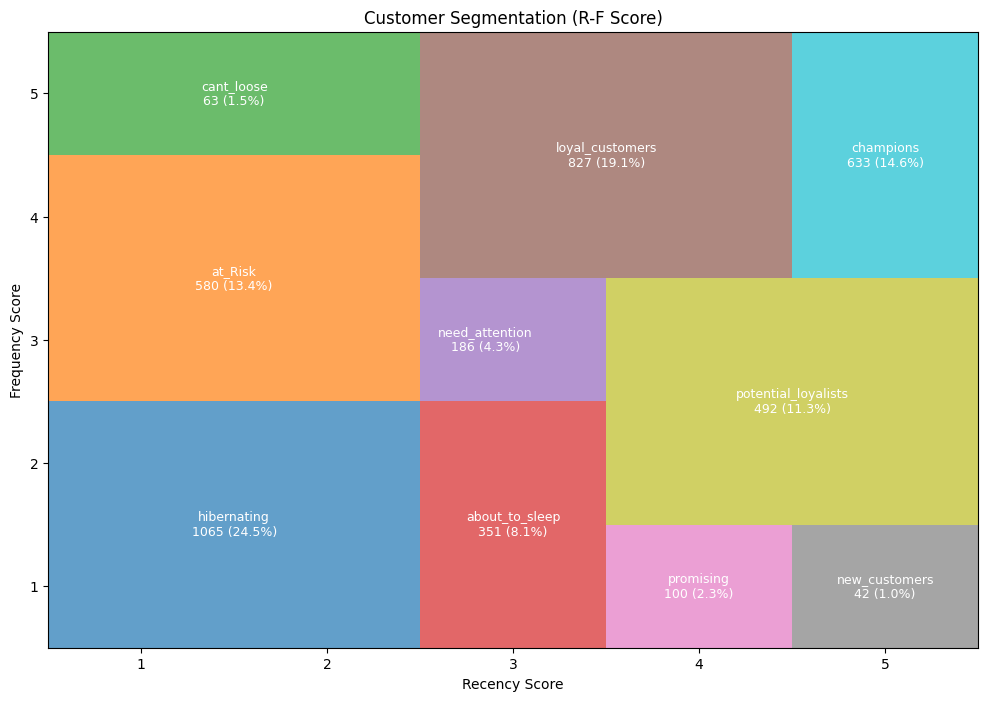

In [12]:
# Step 1: Group the data by segment and count the number of customers in each segment
segment_counts = rfm['segment'].value_counts()
total_customers = segment_counts.sum()
segment_percentages = (segment_counts / total_customers) * 100

# Step 2: Create a figure and axis with a wider size
fig, ax = plt.subplots(figsize=(12, 8))

# Step 3: Define the boundaries for each area and plot colored rectangles
segment_boundaries = {
    'hibernating': [1, 2, 1, 2],
    'at_Risk': [1, 2, 3, 4],
    'cant_loose': [1, 2, 5, 5],
    'about_to_sleep': [3, 3, 1, 2],
    'need_attention': [3, 3, 3, 3],
    'loyal_customers': [3, 4, 4, 5],
    'promising': [4, 4, 1, 1],
    'new_customers': [5, 5, 1, 1],
    'potential_loyalists': [4, 5, 2, 3],
    'champions': [5, 5, 4, 5]
}

cmap = plt.get_cmap('tab10')  # Color map for assigning distinct colors to each segment

for i, (segment, bounds) in enumerate(segment_boundaries.items()):
    rect = plt.Rectangle((bounds[0] - 0.5, bounds[2] - 0.5), bounds[1] - bounds[0] + 1, bounds[3] - bounds[2] + 1,
                         facecolor=cmap(i), alpha=0.7)
    ax.add_patch(rect)

    # Step 4: Add text annotations for segment names, customer count, and percentage
    x_center = (bounds[0] + bounds[1]) / 2
    y_center = (bounds[2] + bounds[3]) / 2
    count = segment_counts[segment]
    percentage = segment_percentages[segment]
    text = f"{segment}\n{count} ({percentage:.1f}%)"

    # Adjust text position to fit within the segment area
    text_x = x_center - 0.15 if segment == 'need_attention' else x_center
    ax.text(text_x, y_center, text, ha='center', va='center', fontsize=9, color='white')

# Step 5: Customize the plot
ax.set_xticks(range(1, 6))
ax.set_yticks(range(1, 6))
ax.set_xticklabels(['1', '2', '3', '4', '5'])
ax.set_yticklabels(['1', '2', '3', '4', '5'])
ax.set_xlim(0.5, 5.5)  # Set X-axis limits to extend to 5.5
ax.set_ylim(0.5, 5.5)  # Set Y-axis limits to extend to 5.5
ax.set_xlabel('Recency Score')
ax.set_ylabel('Frequency Score')
ax.set_title('Customer Segmentation (R-F Score)')


##plt.tight_layout()
plt.show()
